In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import seaborn as sns
from emcee.backends import HDFBackend
import os
os.chdir('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/mcmc/python/model_general')

from astropy.cosmology import Planck18 as cosmos
import astropy.units as u

from read_files import *
from run_mcmc import HODParameter
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

In [ ]:
with open('./configs/config_small_step_pow.yaml', 'r') as f:
# with open('./configs/config_delta.yaml', 'r') as f:
    par_configs, other_configs = list(yaml.load_all(f, yaml.FullLoader))
    # ========== reading configs ==========
    # don't set the lgMmin too large or sig_lgM too small, otherwise N_c will be all zeros
    available_fields = ['Nwalkers', 'Nstep', 'Nburnin', 'Npro', 'auto_range', 'cross_range',
                        'backend_file', 'numpy_file', 'wp_table_path', 'signal_path', 'module_path']
    Nwalkers = 40
    Nstep = 4000
    Nburnin = 300
    Npro = 40
    auto_range = None
    cross_range = None
    backend_file = ''
    numpy_file = ''
    wp_table_path = '../wp_table'
    signal_path = '../signal'
    module_path = './HOD/calc_wp.py'

    for k in available_fields:
        if k in other_configs:
            locals()[k] = other_configs[k]

    wp_table = read_wp(wp_table_path)
    rp_auto, signal_auto, rp_cross, signal_cross = read_signal(signal_path + '/signal.npy')
    cov = read_cov(signal_path + '/cov.npy')
    logM, Nh = read_halo_mass_function('../halo_mass_function.npy')
    module = read_module(module_path)
    chi_2 = module.chi_2
    N_c = module.N_c
    # for better performance I would recommend setting these as global variable
    # ========== apply the fitting range ==========

    if auto_range or cross_range:
        if auto_range is None:
            auto_range = [0, len(rp_auto)]
        if cross_range is None:
            cross_range = [0, len(rp_cross)]
        l_a, r_a = auto_range[0], auto_range[1]
        l_c, r_c = cross_range[0], cross_range[1]

        auto_size = len(rp_auto)
        cross_size = len(rp_cross)
        rp_auto = rp_auto[l_a:r_a]
        rp_cross = rp_cross[l_c:r_c]
        signal_auto = signal_auto[l_a:r_a]
        signal_cross = signal_cross[l_c:r_c]

        cov = np.vstack((
            np.hstack((cov[l_c:r_c, l_c:r_c], cov[l_c:r_c, cross_size+l_a:cross_size+r_a])),
            np.hstack((cov[cross_size+l_a:cross_size+r_a, l_c:r_c], cov[cross_size+l_a:cross_size+r_a, cross_size+l_a:cross_size+r_a]))
        ))

    signal = np.hstack((signal_cross, signal_auto))
    cov_inv = np.linalg.inv(cov)

    # ========== handle interpolating table ==========
    wp_table_auto = interpolate_table(wp_table, rp_auto)
    wp_table_cross = interpolate_table(wp_table, rp_cross)

    parameter = HODParameter.from_config(par_configs)
    dof = len(signal) - parameter.ndim - np.isnan(signal).sum()
    print(parameter)
    print('dof = {}'.format(dof))
    print(dof + np.sqrt(2*dof)*1.96)

HODParameter(lgMmin:    14  [10~17]
             sig_lgM:   0.5 [0.001~1]
             Amp:       1   [fixed]
             lgM0:      12  [11~16]
             lgM1p:     12  [10.5~16]
             alpha:     1   [0~5])
dof = 29
43.92691528749326


In [3]:
if not numpy_file.endswith('.npy'):
    numpy_file += '.npy'
result = np.load(numpy_file)
array_2d = result.view((np.float64, len(result.dtype.names)))
backend = HDFBackend(backend_file, read_only=True)
chain = backend.get_chain(flat=True, discard=5000)
chi2 = -backend.get_log_prob(flat=True, discard=5000)*2
blobs = backend.get_blobs(discard=5000, flat=True)

print('chi^2 = {}'.format(chi2.mean()))

chi^2 = 40.60289221407896


In [4]:
blobs = backend.get_blobs(discard=5000, thin=500, flat=True)

0.01019774871333487-0.0036613648564499677+0.008184852311311872


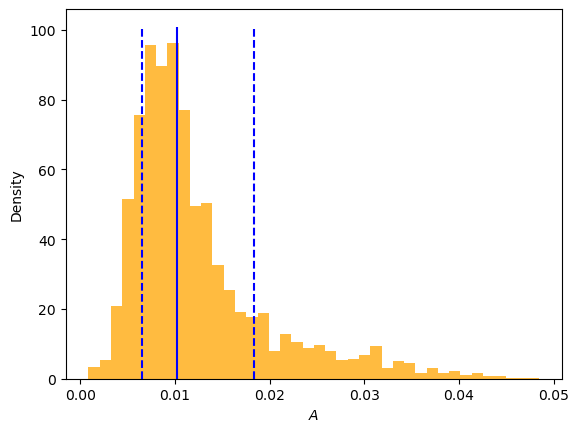

In [5]:
d, m, u = np.percentile(blobs['amp'], [50-34.1, 50, 50+34.1])
print('{}-{}+{}'.format(m, m-d, u-m))
axe = sns.histplot(blobs['amp'], bins=40, stat='density', linewidth=0, color='orange', fill=True)
axe.set_xlabel('$A$')
bottom, top = axe.get_ylim()
axe.vlines([d, u], bottom, top, colors='blue', linestyles='dashed')
axe.vlines([m], bottom, top, colors='blue', linestyles='solid')

0.08990144638889642-0.08990143159962512+0.17232720136196472


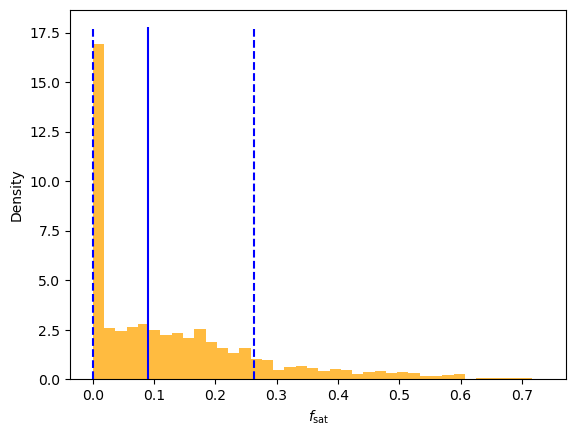

In [5]:
dat = blobs['fsat']#[chi2 < np.percentile(chi2, 50)]
d, m, u = np.percentile(dat, [50-34.1, 50, 50+34.1])
print('{}-{}+{}'.format(m, m-d, u-m))
axe = sns.histplot(dat, bins=40, stat='density', linewidth=0, color='orange', fill=True)
axe.set_xlabel(r'$f_{\text{sat}}$')
bottom, top = axe.get_ylim()
axe.vlines([d, u], bottom, top, colors='blue', linestyles='dashed')
axe.vlines([m], bottom, top, colors='blue', linestyles='solid')

In [5]:
chain_plot = backend.get_chain(discard=5000, thin=300, flat=True)
# chain = backend.get_chain(discard=5000, flat=True)

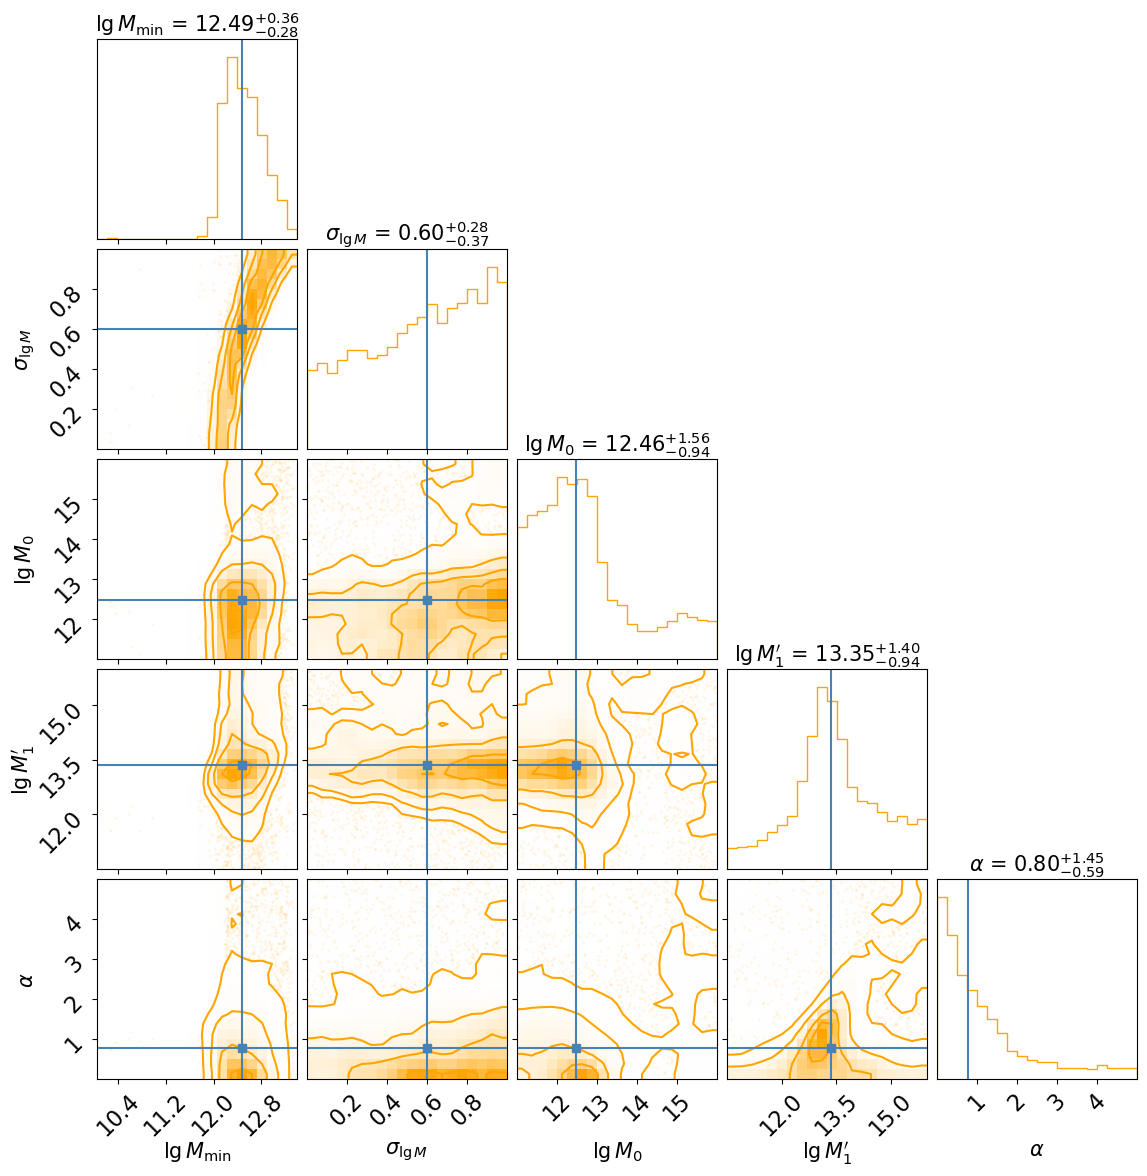

In [14]:
fig = corner.corner(chain_plot, labels=[
    r'$\lg M_{\text{min}}$',
    r'$\sigma_{\lg M}$',
    r'$\lg M_0$',
    r"$\lg M_1 '$",
    r'$\alpha$'], show_titles=True, color='orange', 
    truths=np.percentile(array_2d, 50, axis=0), smooth=0.8,
    title_kwargs={'fontsize': 15}, label_kwargs={'fontsize': 15})

plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/mcmc.pdf')
plt.show()

In [6]:
chain = backend.get_chain(flat=True, discard=5000, thin=500)
blobs = backend.get_blobs(discard=5000, thin=500, flat=True)
chi2 = -backend.get_log_prob(flat=True, discard=5000, thin=500)*2

In [6]:
import tqdm
ncs = []
nss = []
res = chain
for c in tqdm.tqdm(res):
    par = parameter.full_parameters(c)
    ncs.append(module.N_c(logM, par))
    nss.append(module.N_s(logM, par))
ncs = np.array(ncs)
nss = np.array(nss)

 33%|███▎      | 835/2500 [00:00<00:00, 4178.41it/s]

100%|██████████| 2500/2500 [00:00<00:00, 4141.97it/s]


In [7]:
ncs1 = ncs * (blobs['amp'].reshape((-1, 1)) @ np.ones(shape=(1, ncs.shape[1])))
nss1 = ncs * nss * (blobs['amp'].reshape((-1, 1)) @ np.ones(shape=(1, ncs.shape[1])))

In [10]:
mpl.defaultParams['font.size']

[10.0,
 <function matplotlib.rcsetup._make_type_validator.<locals>.validate_float(s)>]

In [21]:
mpl.rcParams['font.size'] = 15

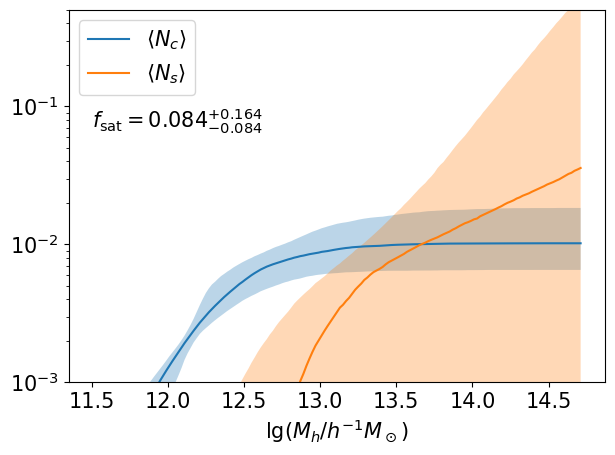

In [24]:
nc = np.percentile(ncs1, 50, axis=0)
ns = np.percentile(nss1, 50, axis=0)

ncu = np.percentile(ncs1, 50+34.1, axis=0)
nsu = np.percentile(nss1, 50+34.1, axis=0)
ncd = np.percentile(ncs1, 50-34.1, axis=0)
nsd = np.percentile(nss1, 50-34.1, axis=0)

# ncu = ncs1.max(axis=0)
# nsu = nss1.max(axis=0)
# ncd = ncs1.min(axis=0)
# nsd = nss1.min(axis=0)

plt.plot(logM, nc, label=r'$\langle N_c\rangle $')
plt.plot(logM, ns, label=r'$\langle N_s\rangle$')
plt.fill_between(logM, ncd, ncu, alpha=0.3)
plt.fill_between(logM, nsd, nsu, alpha=0.3)
plt.semilogy()
plt.ylim(bottom=1e-3, top=0.5)

plt.xlabel(r'$\lg (M_h / h^{-1}M_\odot)$', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.text(11.5, 0.07, r'$f_{\text{sat}} = 0.084_{-0.084}^{+0.164}$', fontsize=15)
plt.tight_layout()

plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/nsnc.pdf', bbox_inches='tight')
plt.show()
# Nc = (nc*Nh).sum()
# Ns = (nc*ns*Nh).sum()

# print('Nq = {}'.format(Nc+Ns))
# print('fsat = {}'.format(Ns/(Nc+Ns)))

In [5]:
par = parameter.full_parameters(np.percentile(array_2d, 50, axis=0))

In [10]:
rp_auto[:8]

array([0.046, 0.071, 0.11 , 0.171, 0.265, 0.409, 0.634, 0.981])

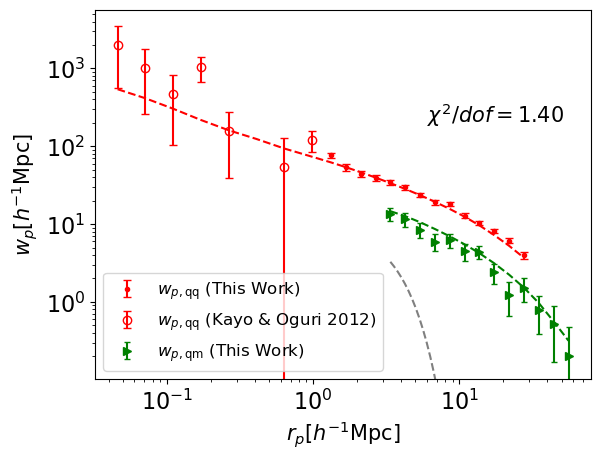

In [17]:
predict = module.w_p(logM, Nh, par, wp_table_auto, wp_table_cross)
pre_cross = predict[:len(rp_cross)]
pre_auto = predict[len(rp_cross):]
std = np.sqrt([cov[i, i] for i in range(len(signal))])
err_cross = std[:len(rp_cross)]
err_auto = std[len(rp_cross):]
# plt.errorbar(rp_auto[:8], signal_auto[:8], err_auto[:8], fmt='ro', linestyle=None, capsize=2, label=r'$w_{p,\mathrm{qq}}$ (Kayo & Oguri 2012)')

plt.errorbar(rp_auto[8:], signal_auto[8:], err_auto[8:], fmt='r.', linestyle=None, capsize=3, label=r'$w_{p,\mathrm{qq}}$ (This Work)')
plt.errorbar(rp_auto[:8], signal_auto[:8], err_auto[:8],
             marker='o', mfc='none', mec='r', ecolor='r', color='r',
             linestyle='None', capsize=3,
             label=r'$w_{p,\mathrm{qq}}$ (Kayo & Oguri 2012)')

plt.errorbar(rp_cross, signal_cross, err_cross, fmt='g>', linestyle=None, capsize=2, label=r'$w_{p,\mathrm{qm}}$ (This Work)')
plt.plot(rp_auto, pre_auto, 'r--')
plt.plot(rp_cross, pre_cross, 'g--')
plt.loglog()

r_pp = np.geomspace(rp_cross[0], rp_cross[-1], 50)

zbar = np.load(f'/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/catalogue/quasar_lss_all.npy')['z'].mean()
fwhm1 = cosmos.comoving_distance(zbar).to('Mpc').value*(6*u.arcmin).to('rad').value*cosmos.h     # h^-1 Mpc
sigma1 = fwhm1 / np.sqrt(8*np.log(2))

tmp_lim = plt.ylim()
plt.plot(r_pp, np.exp(-r_pp*r_pp/(2*sigma1*sigma1))*10, '--', color='grey')
plt.ylim(tmp_lim)

plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$', fontsize=15)
plt.legend(loc='lower left', fontsize=12)


# plt.text(6, 200, f'$\\chi^2 = {chi2.mean():.2f}$\ndof = {dof}', fontsize=15)
plt.text(6, 200, f'$\\chi^2 / dof = {chi2.mean()/dof:.2f}$', fontsize=15)

plt.savefig('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/figure/fit.pdf', bbox_inches='tight')

In [34]:
print(((pre_auto - signal_auto) / err_auto)**2)
print(((pre_cross - signal_cross) / err_cross)**2)
print(np.nan_to_num(((pre_auto - signal_auto) / err_auto)**2).sum(), (((pre_cross - signal_cross) / err_cross)**2).sum())

[2.95535287e-01 3.31442975e-02 7.25752545e-02 3.56381995e+00
 2.76255590e-01            nan 3.79357019e-01 1.37687000e+00
 2.99418022e+00 2.28227598e-01 2.07173782e+00 1.25527656e+00
 6.81520801e-02 4.96360660e-03 5.77577056e-01 8.27302289e-01
 3.59296495e+00 1.91472365e-01 1.25568195e-01 1.74035104e+00
 1.90753001e+00 1.24321525e-01 1.13366523e+01 8.82073011e+00
 2.01658948e+00]
[1.18282031e-01 9.92349623e-02 3.54734933e+00 1.89772719e+00
 2.39187216e-01 2.92901330e-01 2.53191492e-01 1.29399035e+00
 1.60332890e+00 8.44715257e-02 1.88501951e+00 6.05123827e-02
 4.16543791e-07]
43.88115456768998 11.375196638769156
